In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

Loading data for 6 stocks

In [4]:
df0 = pd.read_csv('stocks.csv',header = 0)
df1 = df0.set_index('Date')
df1.head()

,DIS,GE,GILD,GOOGL,KMI,OIL,T,TSLA,WMT
Date,,,,,,,,,
2011-02-11,43.410000,20.509615,19.195000,312.562561,31.049999,31.049999,28.469999,23.25,55.689999
2011-02-14,43.240002,20.673077,19.280001,314.389404,30.700001,30.700001,28.459999,23.08,54.799999
2011-02-15,43.090000,20.634615,19.495001,312.387390,30.940001,30.940001,28.240000,22.84,54.950001
2011-02-16,43.700001,20.615385,19.695000,312.422424,30.719999,30.719999,28.299999,24.73,54.549999
2011-02-17,43.700001,20.692308,19.645000,312.942932,30.549999,30.549999,28.500000,23.60,54.750000


Plotting dataframe

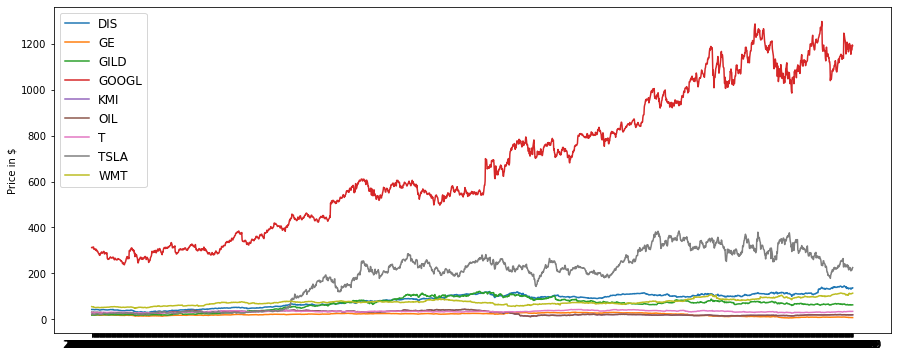

In [5]:
plt.figure(figsize=(15, 6))
for i in range(df1.shape[1]):
    plt.plot(df1.iloc[:,i], label=df1.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.show()

Normalising data

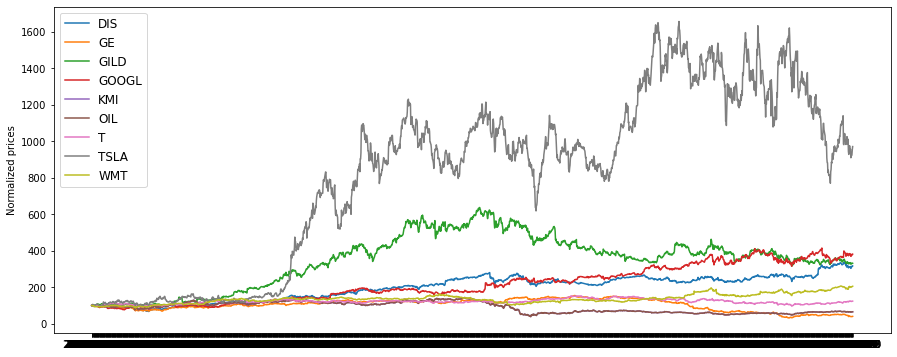

In [6]:
df3 = df1.divide(df1.iloc[0] / 100)

plt.figure(figsize=(15, 6))
for i in range(df3.shape[1]):
    plt.plot(df3.iloc[:,i], label=df3.columns.values[i])
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Normalized prices')
plt.show()

Calculating annulised rate of return

In [7]:
#Calculate daily changes in the stocks' value
df2 = df1.pct_change()
#Remove nan values at the first row of df2. Create a new dataframe df
df=df2.iloc[1:len(df2.index),:]
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
r = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()

Defining some functions that we will use later in our calculation.

1) Rate of return is the annualized rate of return for the whole portfolio.
2) Volatility is the risk level, defined as the standard diviation of return.
3) Sharpe ratio is risk efficiency; it assesses the return of an investment compared to its risk.

In [8]:
#Define frequently used functions.
# r is each stock's return, w is the portion of each stock in our portfolio, and covar is the covariance matrix
# Rate of return
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))
def sharpe (ret,vol):
    return ret/vol

Optimising our portfolio: Let's say we want the lowest level of risk possible. Thus, we should find a portfolio with minimum volatility

In [9]:
# All weights, of course, must be between 0 and 1. Thus we set 0 and 1 as the boundaries.
from scipy.optimize import Bounds
bounds = Bounds(0, 1)

# The second boundary is the sum of weights.
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint(np.ones((df2.shape[1],), dtype=int),1,1)

# Find a portfolio with the minimum risk.
from scipy.optimize import minimize
#Create x0, the first guess at the values of each stock's weight.
weights = np.ones(df2.shape[1])
x0 = weights/np.sum(weights)
#Define a function to calculate volatility
fun1 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
res = minimize(fun1,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

np.set_printoptions(suppress = True, precision=2)
print(w_min)
print('return: % .2f'% (ret(r,w_min)*100), 'risk: % .3f'% vol(w_min,covar))

[0.08 0.04 0.05 0.1  0.04 0.04 0.33 0.   0.33]
return:  8.16 risk:  0.008


Portfolio with the highest level of risk efficiency - that is, a portfolio that has the highest ratio of return/risk

In [10]:
#Define 1/Sharpe_ratio
fun2 = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))/r.dot(w)
res_sharpe = minimize(fun2,x0,method='trust-constr',constraints = linear_constraint,bounds = bounds)

#These are the weights of the stocks in the portfolio with the highest Sharpe ratio.
w_sharpe = res_sharpe.x
print(w_sharpe)
print('return: % .2f'% (ret(r,w_sharpe)*100), 'risk: % .3f'% vol(w_sharpe,covar))

[0.24 0.   0.14 0.24 0.   0.   0.   0.16 0.22]
return:  19.27 risk:  0.011


Plotting the Efficient Frontier

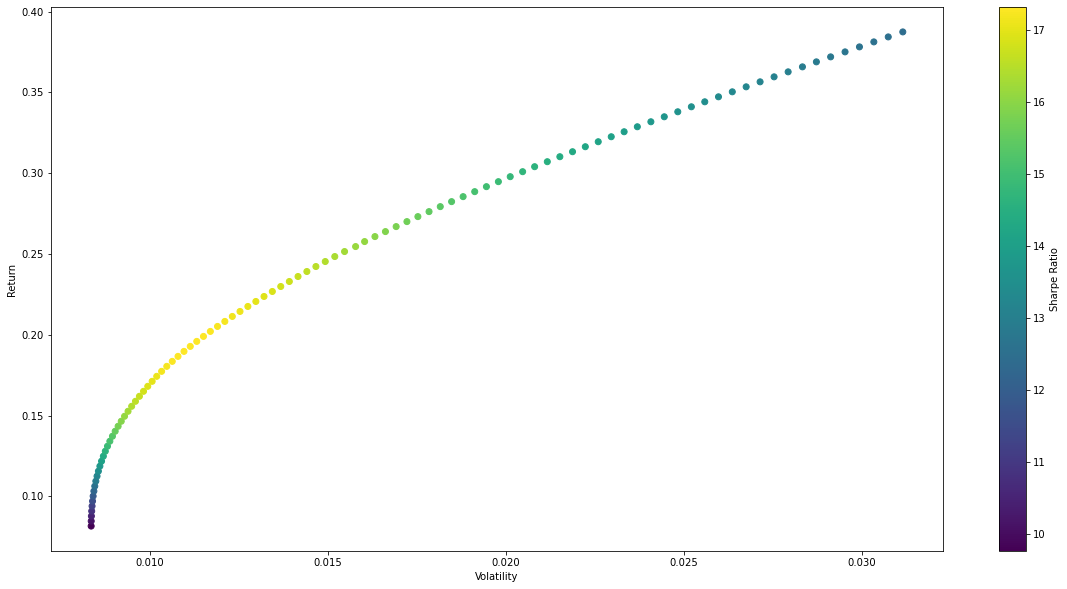

In [11]:
w = w_min
num_ports = 100
gap = (np.amax(r) - ret(r,w_min))/num_ports


all_weights = np.zeros((num_ports, len(df.columns)))
all_weights[0],all_weights[1]=w_min,w_sharpe
ret_arr = np.zeros(num_ports)
ret_arr[0],ret_arr[1]=ret(r,w_min),ret(r,w_sharpe)
vol_arr = np.zeros(num_ports)
vol_arr[0],vol_arr[1]=vol(w_min,covar),vol(w_sharpe,covar)

for i in range(num_ports):
    port_ret = ret(r,w) + i*gap
    double_constraint = LinearConstraint([np.ones(df2.shape[1]),r],[1,port_ret],[1,port_ret])
    
    #Create x0: initial guesses for weights.
    x0 = w_min
    #Define a function for portfolio volatility.
    fun = lambda w: np.sqrt(np.dot(w,np.dot(w,covar)))
    a = minimize(fun,x0,method='trust-constr',constraints = double_constraint,bounds = bounds)
    
    all_weights[i,:]=a.x
    ret_arr[i]=port_ret
    vol_arr[i]=vol(a.x,covar)
    
sharpe_arr = ret_arr/vol_arr  

plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()